In [1]:
import copy
import random
import time
import os
import re

import torch
import torch.nn as nn
import torch.nn.functional 
import torch.optim 
import torch.utils.data

import torchvision.transforms
import torchvision.datasets

import skimage.io
import skimage.transform
import sklearn.preprocessing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Functions

In [2]:
def set_seeds(seed):
    """sets seeds for several used packages"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
def encode_column(column):
    """
    takes single columned Pandas DataFrame of categorical data and encodes it
    into array of class binarys
    """
    encoder = sklearn.preprocessing.OneHotEncoder()
    shape_arr = encoder.fit_transform(column).toarray().astype(int)
        
    return list(shape_arr)

In [4]:
def prep_data(labels, image_root):
    """
    Takes in raw labels dataframe and converts it into the format
    expected for tenX_dataset class
    """

    #Splitting description column into color and shape columns
    new = labels["Description"].str.split(" ", n=1, expand=True)
    labels.drop(columns=['Description'], inplace=True)
    labels['Color'] = new[0].values
    labels['Shape'] = new[1].values
    
    #Decomposing sample keywords into seperate strings
    sample_names = labels["Sample"].str.split(" ", n=1, expand=False)
    labels['Sample'] = sample_names
    
    #Converting identification into boolean for is/is not plastic
    PLASTICS = ['polystyrene', 'polyethylene','polypropylene','Nylon','ink + plastic','PET','carbon fiber']
    identification = labels['Identification']
    
    for i in range(0,len(identification)):
        if identification[i] in PLASTICS:
            identification[i] = True
        else:
            identification[i] = False

    labels['Identification']=identification
    labels.rename(columns={'Identification': 'isPlastic'}, inplace=True)
    labels['isPlastic'] = labels["isPlastic"].astype(int)
    
    
    #Encoding shape and color data
    labels['Shape'] = encode_column(labels[['Shape']])
    labels['Color'] = encode_column(labels[['Color']])
    
    labels = add_filenames(labels, image_root)
    
    return labels

In [5]:
def add_filenames(labels, image_root):
    """
    Replaces sample column of labels with the actual filename so that the dataset class doesn't have to do that work.
    """
    image_filenames = os.listdir(image_root)
    labels.insert(loc=1, column='File', value=None)
    for index, row in labels.iterrows():
        sample = row['Sample']
        for fname in image_filenames:
            str_id = '^' + ' '.join(row['Sample']) + ' .*'
            result = re.search(str_id, fname)
            if result:
                image_file = result.group()
                assert(os.path.exists('./data/images_10x/' + image_file))
                break
        else:
            image_file = None
        labels.loc[index, 'File'] = image_file
    return labels

In [6]:
#remove nonetypes
def remove_nones(df):
    for index, row in df.iterrows():
        if row['File'] == None:
            df.drop(index, inplace=True)
    df = df.reset_index(drop=True)
    return df


# Custom Dataset

In [7]:
class tenX_dataset(torch.utils.data.Dataset):
    """
    Class inherited from torch Dataset. Required methods are, init,
    len, and getitem.
    """
    def __init__(self, labels_frame, image_dir, transform):
        """
        initializes an instance of the class. Here we store 4 variables
        in the class. Calling init just looks like dataset = tenX_dataset(lables, 'image_folder', transform).
        
        labels: altered version of csv file
        image_dir: The file path to the folder the images are in
        image_filenames: A list of all the image file names in the image folder
        transform: A pytorch object. Works like a function. You call transform(x) and it performs
                    a series of operations on x
        """
        self.labels = labels_frame
        self.image_dir = image_dir
        self.image_filenames = os.listdir(self.image_dir)
        self.transform = transform
        

    def __len__(self):
        """Returns the length of the dataset"""
        return len(self.labels)
    
    
    def __getitem__(self, idx):
        """
        Returns a dictionary containing image and image data. Right now
        it looks like: 
        sample = {'image': image, 'plastic': [0], 'shape':[0,0,0,0,0], 'color':[0,0,0,0,0]}
        """
        image_filename = self.labels['File'][idx]
        image = None
             
        if image_filename is not None:
            image_filepath = os.path.join(self.image_dir, image_filename)
            image = skimage.io.imread(image_filepath)
            if self.transform is not None:
                image = self.transform(image)

        sample = {'image': image,
                  'shape': self.labels['Shape'][idx],
                  'color': self.labels['Color'][idx],
                  'plastic': self.labels['isPlastic'][idx]}
  
        return sample

### Plotting first 20 images of dataset. Obviously getting quite a few duplicates

/opt/anaconda3/envs/fmpm/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/fmpm/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/fmpm/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


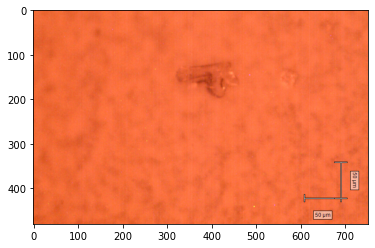

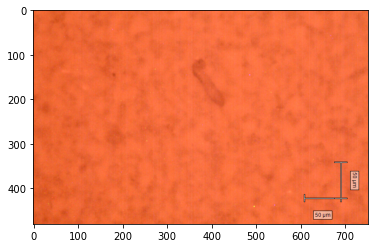

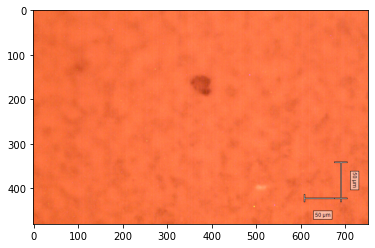

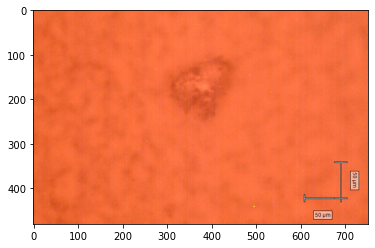

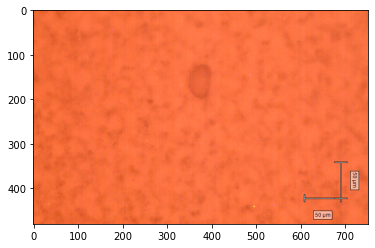

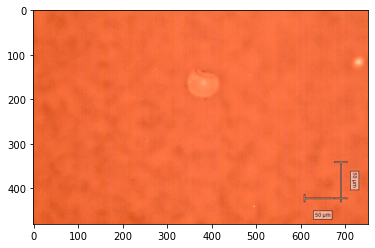

<Figure size 432x288 with 0 Axes>

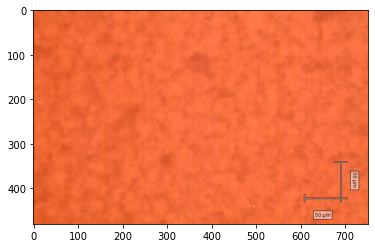

<Figure size 432x288 with 0 Axes>

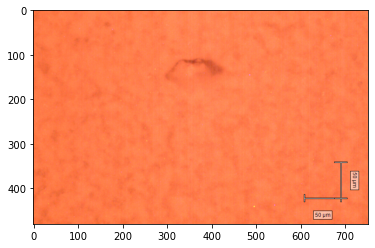

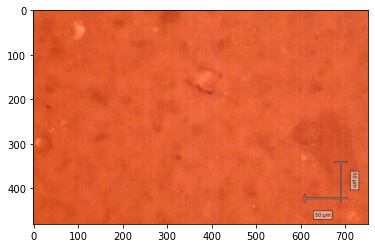

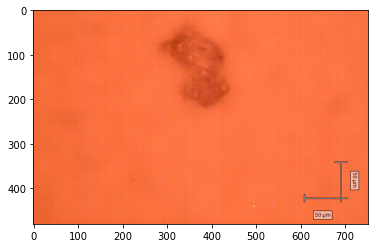

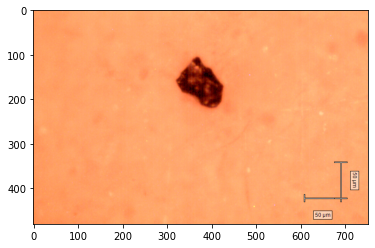

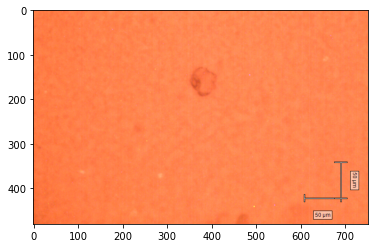

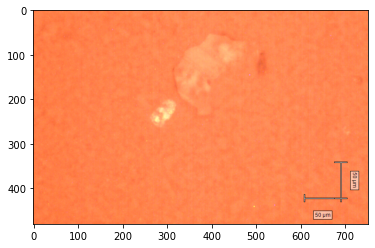

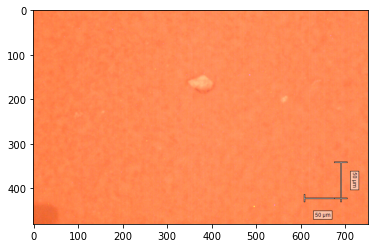

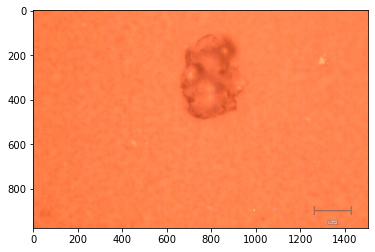

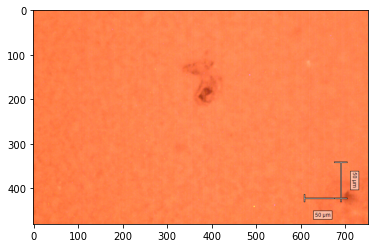

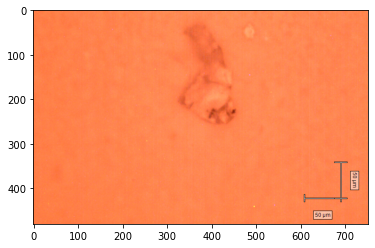

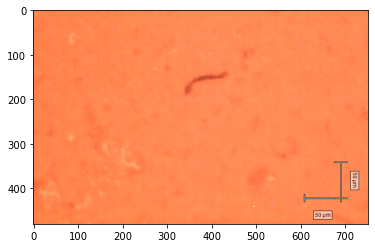

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [8]:
labels_filepath = 'data/10x_labels_more.csv'
image_dir = 'data/images_10x'
labels = prep_data(pd.read_csv(labels_filepath, delimiter='\t'), image_dir)
tenX = tenX_dataset(labels, image_dir, None)


for i in range(len(tenX)):
    sample = tenX[i]
    plt.figure(i)
    if sample['image'] is not None:
        plt.imshow(sample['image'])
    if i>20:
        break

# Things to improve/fix
* Make sure the nonetypes are because the file actually isn't in my folder of images
* Code for normalizing image data
* Image augmentation. Probably want to cut off some of the edges to get rid of number stuff and decrease extraneous information. The think we actually care about is only occupying like 5-10% of the image.

# CNN 

starting from simple test network lik eher:https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html


In [9]:
from torch.utils.data import random_split
import torch.nn 
import torch.nn.functional

In [10]:
labels_frame = remove_nones(prep_data(pd.read_csv('data/10x_labels_more.csv', delimiter='\t'), image_dir))
labels_frame.head(n=30)

/opt/anaconda3/envs/fmpm/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/fmpm/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Sample,File,Sample origin,Size (um),isPlastic,Color,Shape
0,[252_1],252_1 - 10x.bmp,mussels,50.0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,[252_2],252_2 - 10x.bmp,mussels,50.0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,[252_3],252_3 - 10x.bmp,mussels,25.0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,[252_4],252_4 - 10x.bmp,mussels,75.0,1,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,[252_5],252_5 - 10x.bmp,mussels,50.0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,[252_6],252_6 - 10x.bmp,mussels,50.0,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,[252_8],252_8 - 10x.bmp,mussels,30.0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,[252_10],252_10 - 10x.bmp,mussels,50.0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,"[20200824, 250_1]",20200824 250_1 - 10x.bmp,mussels,40.0,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,"[20200824, 252_1]",20200824 252_1 - 10x.bmp,mussels,100.0,0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
image_dir = 'data/images_10x'
labels_frame = remove_nones(prep_data(pd.read_csv('data/10x_labels_more.csv', delimiter='\t'), image_dir))

#This transform just resizes the images to 3,480,752. So 3 for red green blue then height of 480
#and width of 752. 
transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.Resize((480, 752)),
                            torchvision.transforms.ToTensor()
                                      ])


/opt/anaconda3/envs/fmpm/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/envs/fmpm/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
#tenX = tenX_dataset(labels_frame, image_dir, transform = transform)\

In [26]:
# for i in range(len(tenX)):
#     sample = tenX[i]

#     print(i, sample['image'].shape, sample['plastic'].shape)
# print(len(tenX))

In [27]:
#split_ratio = 0.7

#n_train_examples = int(len(train_data) * split_ratio)
#n_valid_examples = len(train_data) - n_train_examples

#train_data, test_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

In [28]:
train_df = (labels_frame.sample(frac = 0.75))
test_df = (labels_frame.drop(train_df.index))
train_df = train_df.reset_index()
test_df = test_df.reset_index()

In [47]:
train_set = tenX_dataset(train_df, image_dir, transform = transform)
test_set = tenX_dataset(test_df, image_dir, transform = transform)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=3, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=2)

In [48]:
print(len(test_set))
print(len(train_set))
print(len(trainloader))

83
250
84


In [49]:
import torch.nn as nn
import torch.nn.functional


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        #self.pool = torch.nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        self.fc1 = nn.Linear(259740, 6)
        self.fc2 = nn.Linear(6, 6)
        self.fc3 = nn.Linear(6,2)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.max_pool2d(x, kernel_size = 2)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.max_pool2d(x, kernel_size = 2)
        x = nn.functional.relu(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)    
        x = nn.functional.relu(x)
        x = self.fc2(x)    
        x = nn.functional.relu(x)
        x = self.fc3(x)    
#         x = self.pool(torch.nn.functional.relu(self.conv1(x)))
#         x = self.pool(torch.nn.functional.relu(self.conv2(x)))
#         x = x.view(x.shape[0], -1)
#         x = nn.functional.relu(self.fc1(x))
#         x = nn.functional.relu(self.fc2(x))
#         x = self.fc3(x)
        return x
    


net = Net()

In [50]:
#defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [51]:
print('hi')
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs = data['image']
        labels = data['plastic']

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs =  net(data['image'])
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

hi
Finished Training


In [52]:
PATH = './trained_test1.pth'
torch.save(net.state_dict(), PATH)

In [53]:
dataiter = iter(testloader)
images = dataiter.next()['image']
labels = dataiter.next()['plastic']


In [54]:
outputs = net(images)

In [55]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images = data['image']
        labels = data['plastic']
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %d %%' % (len(testloader),
    100 * correct / total))

Accuracy of the network on the 83 test images: 96 %


# Start of me trying to plug into cnn

Most of the code came from this tutorial: https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb

I was just trying to get this to work so I won't understand it as much

In [ ]:
image_dir = 'data/images_10x'
labels_frame = labels

#This transform just resizes the images to 3,480,752. So 3 for red green blue then height of 480
#and width of 752. 
transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.Resize((480, 752)),
                            torchvision.transforms.ToTensor()
                                      ])


train_data = tenX_dataset(labels_frame, image_dir, transform = transform)

In [ ]:
image_dir = 'data/images_10x'
labels_frame = remove_nones(prep_data(pd.read_csv('data/10x_labels_more.csv', delimiter='\t'), image_dir))
transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToPILImage(),
                            torchvision.transforms.Resize((480, 752)),
                            torchvision.transforms.ToTensor()
                                      ])


train_data = tenX_dataset(labels_frame, image_dir, transform = transform)

#### Splitting into train/validation set

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')

#### Declaring iterator. The thing that will loop through our dataset.

In [ ]:
BATCH_SIZE = 5

train_iterator = torch.utils.data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

#### The CNN archetecture

In [ ]:
class LeNet(nn.Module):
    def __init__(self, output_dim):
        """
        Initializes CNN. Here we just define layer shapes that we call in the forward func
        """
        super().__init__()

        #Convulution layer 1. 
        #3 input channels (for three images Red, Green, Blue)
        #6 output channels (I THINK this means we are applying two different filters to each image
        #3 images, two filters each, we end up with 6 'images')
        #kernel size is I THINK telling the filters took filter each set of 5 pixels into one.
        #So are images will shrink a little as the edges get cut off
        self.conv1 = nn.Conv2d(in_channels = 3, 
                               out_channels = 6, 
                               kernel_size = 5)
        
        #Convultion layer 2. See above
        self.conv2 = nn.Conv2d(in_channels = 6, 
                               out_channels = 12, 
                               kernel_size = 5)
        
        #Linear layers. These probably arent complicated but I don't follow haha
        #I think it turning the 259740 pixel values into 6 values. Then the second layers
        #Turns the 6 into a different 6? and then 6 into 2. I'm not sure why 2 and not 1.
        #Seeing as the output should be a number between 0-1. Closer to 0 = not plastic,
        #closer to 1 = plastic. But I got errors about not having enough classes when
        #I only had 1 output neuron.
        #TBH these linear layers I just changed based on the error messages I got.
        self.fc_1 = nn.Linear(259740, 6)
        self.fc_2 = nn.Linear(6, 6)
        self.fc_3 = nn.Linear(6, 2)

    def forward(self, x):
        """
        Function that performs all the neural network forward calculation i.e.
        takes image data from the input of the neural network to the output
        """

        
        x = self.conv1(x)
    
        #Gonna have to look at tutorial link.
        x = nn.functional.max_pool2d(x, kernel_size = 2)
        
        x = nn.functional.relu(x)
        
        x = self.conv2(x)
                
        x = nn.functional.max_pool2d(x, kernel_size = 2)
        
        x = nn.functional.relu(x)
        
        x = x.view(x.shape[0], -1)
                
        h = x
        
        x = self.fc_1(x)
                
        x = nn.functional.relu(x)

        x = self.fc_2(x)
                
        x = nn.functional.relu(x)

        x = self.fc_3(x)
        
        return x, h

In [ ]:
#Instancing model, loss criteria, device to perform calculations on, and optimizer.
OUTPUT_DIM = 1
model = LeNet(OUTPUT_DIM)


criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
#Telling the model and loss function to do math on whatever device is
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
def calculate_accuracy(y_pred, y):
    """
    Function calculate accuracy. See tutorial, may not
    even be accurate for our model but it at least runs
    """
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion, device):
    """
    Training loop. Takes data through NN calculates loss and adjusts NN. Repeat
    """
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    #Need to add logic to skip iteration if image is None
    for sample in iterator:  
        
        image = sample['image'].to(device)
        isPlastic = sample['plastic'].to(device)
                
        optimizer.zero_grad()      
        y_pred, what = model(image)

        loss = criterion(y_pred, isPlastic)
        acc = calculate_accuracy(y_pred, isPlastic)
        loss.backward()    
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#Here the model is actually trained
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

    
    end_time = time.monotonic()

    #epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    #print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    #print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')